# Data analysis with SciAnalysis

last updated: 2023 May

In this notebook, we can load the raw tiff, load or extract metedata, analysis the data, save the analysis results and metadata in .H5.

--------------------------------------

*exp.dict*: The experiment dictionary. 'Experiment' is a series of measurements, e.g. in-situ thermal annealing measurements of a sample.

*exp.dict.keys()*: ['analysis', 'corr', 'corrdata', 'data', 'detector', 'exp_protocol', 'expinfo', 'expname', 'folder', 'mdata_list', 'metadata']

--------------------------------------

# &#9635; SciAnalysis for Experiment

At home insitute, download SciAnalysis at: https://github.com/CFN-softbio/SciAnalysis



In [2]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime, pprint, math
import sqlite3
import pandas as pd
from silx.io.dictdump import dicttoh5, h5todict

SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols

from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools

now = datetime.datetime.now()
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
print("{}\n".format(dt_string))

# %pwd

2023/07/03 16:15:31



## 0. Calibration

__Direct beam (if available)__

__Calibration: Energy, beam center, SD distance__

1. Specify wavelength 
2. Tweak beam center and SD distance to get the best match for the calibrant

__Convert between q and angle__

## 1. Raw data

## Notes for KWhite data in 2023C2

### Use scanid to load the series_measure data `exp.defFiles_ScanID_ONLY`


In [29]:
# exp.defFiles(fn=pattern, verbose=1)

In [184]:
### Specify directory, detector, and files of interest

    
if 1: 
    # EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/' 
    # samplefolder_load = 'sam99_1mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_011' # sam16_3mai1pbi2_dmf_1m_5scfh_Si_40uL_010
    # scanid = 1116248
    
    samplefolder_load = 'sam98_3mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_012' # sam16_3mai1pbi2_dmf_1m_5scfh_Si_40uL_010
    scanid = 1116272
    
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/'  + samplefolder_load + '/'
    exp = Experiment.experiment(samplefolder_load, folder=EXPR_DIR, det='maxs', series_measure=True, beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = [f'{samplefolder_load}*']  


### Load files
try:
    for pattern in exp.dict['expinfo']['fn_patterns']:
        #exp.defFiles_query(fn='PBG', folder=EXPR_DIR, scanid = [900000, 1200000], verbose=1) 
        print(f'pattern = {pattern}')
        # exp.defFiles(fn=pattern, verbose=1) 
        # exp.defFiles(fn=pattern, scanid = [750000, 900000], verbose=1)  
        # infiles = exp.defFiles_ScanID_ONLY(fn=pattern, scanid = [1116002], verbose=1)  
        infiles = exp.defFiles_ScanID_ONLY(fn=pattern, scanid = [scanid], verbose=1)  
    
    # infiles = exp.dict['rawinfo']['filename']
    Nfiles = len(infiles)
    
except:
    print('\n!!! Databroker not working, loading files directly.')
    #exp.dict['expinfo']['beamline'] = None
    for pattern in exp.dict['expinfo']['fn_patterns']:
        exp.defFiles_ScanID_ONLY(fn=pattern, scanid = [scanid], verbose=1)  
    

### Show some info   
exp.show()
exp.showFileInfo(idx=0)

pattern = sam98_3mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_012*
/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/sam98_3mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_012/maxs/raw/
Loaded 622 files.
(defFiles time = 1.4s)

=== Overview of experiment dictionary ===
exp.dict['expinfo']
  -  keys = ['expname', 'det', 'beamline', 'folder', 'ext', 'fn_patterns']
  -  key = expname, <class 'str'>, val = sam98_3mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_012
  -  key = det, <class 'str'>, val = maxs
  -  key = beamline, <class 'str'>, val = cms
  -  key = folder, <class 'str'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/sam98_3mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_012/
  -  key = ext, <class 'str'>, val = tiff
  -  key = fn_patterns, <class 'list'>
exp.dict['rawinfo']
  -  keys = ['filename', 'time', 'clock', 'scan_id', 'uid', 'filenumber', 'series_measure', 'num_frames']
  -  key = filename, <class 'list'>, len(shape) = 622
  -  key = time, <class 'list'>, len(shape) = 622
  -  key = clock, <class 'list'>,

## 2. Metadata

In [182]:
## See metadata for one file
import databroker
cat = databroker.catalog['cms']
scan_id = exp.dict['rawinfo']['scan_id'][0]  #959455
# scan_id = 1116295
scan_id = 1116317

scan_id = 1112650

query = {'scan_id': {'$gte': scan_id, '$lte': scan_id}, 
        }
res = cat.search(query)

# h = cat[scan_id]
# h.metadata['start']
for _uid in res:
    print(cat[_uid].metadata['start']['scan_id'], cat[_uid].metadata['start']['experiment_group'], cat[_uid].metadata['start']['plan_name'])

1112650 Frank Bates (UM) count
1112650 O. Chen( Brown U.) count


In [183]:
cat[list(res)[0]].metadata['start']

Start({'beam_int_bim3': 0.0,
 'beam_int_bim4': 0.0,
 'beam_int_bim5': 0.0,
 'beam_intensity_expected': 20000,
 'beam_size_x_mm': 0.1999979999999999,
 'beam_size_y_mm': 0.20000474999999973,
 'beamline_mode': 'measurement',
 'calibration_energy_keV': 13.5,
 'calibration_wavelength_A': 0.9184,
 'detector_sequence_ID': 0,
 'detectors': ['pilatus2M', 'pilatus800'],
 'experiment_SAF_number': '311451',
 'experiment_alias_directory': '/nsls2/data/cms/legacy/xf11bm/data/2023_2/FBates/',
 'experiment_cycle': '2023_2',
 'experiment_group': 'Frank Bates (UM)',
 'experiment_project': 'Dynamics of micelle and liquid crystal formation in '
                       'systems of blended amphiphiles',
 'experiment_proposal_number': '312640',
 'experiment_type': 'SAXS/WAXS',
 'experiment_user': 'various',
 'filename': 'SX_cap_JMW_P15_R10_48h_anneal_3_T50.945C_x0.000_y0.300_10.00s_1112650',
 'hints': {'dimensions': [[['time'], 'primary']]},
 'measure_type': 'measure',
 'motor_SAXSx': -65.0,
 'motor_SAXSy': -

In [178]:
uid = '28aacc73'
h = cat[uid]

In [181]:
h.metadata

{'start': Start({'beam_intensity_expected': 20000,
 'calibration_energy_keV': 17.0,
 'calibration_wavelength_A': 0.72932,
 'experiment_SAF_number': '311268',
 'experiment_alias_directory': '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/sam26_3mai1pbi2_dmso_1m_5scfh_Si_40uL_014',
 'experiment_cycle': '2023_2',
 'experiment_group': 'K. White (Colorado U)',
 'experiment_project': 'In-situ GIWAXS of bladecoated metal halide perovskite '
                       'thin films to assess the impact of precursor solution '
                       'colloids on the evolution of intermediate solvate '
                       'structures',
 'experiment_proposal_number': '311415',
 'experiment_type': 'spin-coating GIWAXS',
 'experiment_user': 'various',
 'plan_name': 'runSpinner',
 'plan_type': 'generator',
 'platform_beam': 45,
 'sample_clock_zero': 1685067895.8167915,
 'scan_id': 1116317,
 'time': 1687893140.0703251,
 'uid': '28aacc73-b823-442d-8c13-d140915e0c07'}),
 'stop': Stop({'exit_status': 'su

In [185]:
## Options: (1) load metadata from databroker at beamline. (2) load md from h5. (3) Extract info from filename
md_load_option = 1

## Clear all metadata
exp.dict['metadata'] = {}


## Load metadata
if md_load_option==1: # Load md from databroker, this only works at beamline
    exp.dict['mdata_list'] = ['scan_id'] # Specify metedata to load
    exp.loadMetadata()
    print(exp.dict['metadata'].keys())
    
elif md_load_option==2: # Load md from h5 (previously saved from databroker)
    h5_path = EXPR_DIR+"/data/"
    h5_file = 'B6_N3_metadata.h5'
    exp.dict['metadata'] = h5todict(h5_path+h5_file)


elif md_load_option==3: ## If databroker md is not available nor saved
    infiles = exp.dict['rawinfo']['filename']
    print('Number of files: {}'.format(len(infiles)))

    Ts = []
    sample_x = []
    sample_y = []
    scan_id = []
    frames = []
    for ii, infile in enumerate(infiles):
        temp = infile.split('_')
        if ii==0: print(temp)
        
        Ts.append(float(infile.split('Linkam')[1].split('C')[0]))
        #sample_x.append(float(temp[-4][1:]))
        #sample_y.append(float(temp[-3][1:]))
        
        #Ts.append(float(infile.split('RH')[1].split('_x')[0]))
        #scan_id.append(int(temp[-1]))
        #frames.append(int(temp[-1]))

    exp.dict['metadata']['sample_temperature_D'] = Ts
    #exp.dict['metadata']['sample_x'] = np.array(sample_x)
    #exp.dict['metadata']['sample_y'] = np.array(sample_y)
    #exp.dict['metadata']['frames'] = frames
    
    print(exp.dict['metadata'].keys())

else:
    print('No metadata loaded to the exp. dictionary!')

[0%] 
[32%] 
[64%] 
[96%] 
(loadMetadata time = 0.5s)
dict_keys(['scan_id'])


## 3. Analysis

We suspect that loading analysis results is slow, faster if processing raw data. However, going through the protocals is also slow; storing it to the exp.dict also takes a bit time.

E.g. 3600 files, 1 protocol, saving to exp.dict: 5min

In [186]:
### Specify beamline config (e.g. beam energy, center, det-sample distance)




if 1: #WAXS, MAXS
    #calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration = Calibration(wavelength_A=12.4/12.7) #13.5 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    
    calibration.set_beam_position(576, 1043-390) # Pilatus 800k x=450 y=398 works in xi-cam, in scianalysis need y=1043-398=645
    calibration.set_distance(0.3)

    ## LRichter
    if 0:
        calibration.set_beam_position(543, 606) #LRichter
        calibration.set_distance(0.2815)
    
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k2_gaps-mask.png')
    mask.load('./Pilatus800k2_custom-mask.png')

  
    
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            #'save_results' : ['xml', 'plots', 'txt', 'hdf5'],
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)


### Run analysis 
protocols = ['circular_average'] #['linecut_angle'] #['circular_average'] #, 'sector_average', 'linecut_qz']

exp.dict['analysis']['cali'] = [calibration.wavelength_A, calibration.x0, calibration.y0, calibration.distance_m]
#exp.dict['analysis'] = {} 
#for protocol in protocols:
#    exp.dict['analysis'][protocol] = {}

t0 = time.time()  
    
line_y_stack = []
for protocol in protocols:
    if 'circular_average' in protocol:
        for ii, infile in enumerate(infiles):
            if np.mod(ii+1, 50)==0: print('[{:.0f}%]'.format(ii/Nfiles*100))

            det = exp.dict['expinfo']['det']
            folder = exp.dict['expinfo']['folder']

            # infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
            infile_fullpath = infile
            # print(infile_fullpath)
            data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

            ### Run the protocol
            line_output = data.circular_average_q_bin(error=False)
            line_y_stack.append(line_output.y)

            if 0:
                exp.dict['analysis'][protocol][str(ii)] = {}
                exp.dict['analysis'][protocol][str(ii)]['q'] = line_output.x
                exp.dict['analysis'][protocol][str(ii)]['I(q)'] = line_output.y
        
        ### Save analysis to exp.dict
        if 1:
            exp.dict['analysis'][protocol] = {}
            exp.dict['analysis'][protocol]['q'] = line_output.x
            exp.dict['analysis'][protocol]['I_stack'] = line_y_stack   
            #x = Protocols.thumbnails(name=None) 
            #x.run(data, output_dir)
            
    if 'linecut_qr' in protocol:
        for ii, infile in enumerate(infiles):
            if np.mod(ii+1, 50)==0: print('[{:.0f}%]'.format(ii/Nfiles*100))

            det = exp.dict['expinfo']['det']
            folder = exp.dict['expinfo']['folder']

            infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
            data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

            ### Run the protocol
            line_output = data.linecut_qr(qz=0.03, dq=0.003)
            line_y_stack.append(line_output.y)

        ### Save analysis to exp.dict
        if 1:
            exp.dict['analysis'][protocol] = {}
            exp.dict['analysis'][protocol]['q'] = line_output.x
            exp.dict['analysis'][protocol]['I_stack'] = line_y_stack           
        
    #elif 'sector_average' in protocol: 
    #    line_output = data.sector_average_q_bin(angle=60, dangle=5)

    #elif 'linecut_qz' in protocol:
    #    line_output = data.linecut_qz(qr=0, dq=0.05)

    #elif 'linecut_angle' in protocol:
    #line_output = data.linecut_angle(q0=2.24, dq=0.01)
            
        
print('Done! (Analysis took {:.0f}s)\n'.format(time.time()-t0))

now = datetime.datetime.now()
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
print("{}\n".format(dt_string))

print(exp.dict['analysis'].keys())

[8%]
[16%]
[24%]
[32%]
[40%]
[48%]
[56%]
[64%]
[72%]
[80%]
[88%]
[96%]
Done! (Analysis took 63s)

2023/07/02 13:32:58

dict_keys(['cali', 'circular_average'])


## 4. Save 

Save experiment dictionary (exp.dict) to h5.

In [187]:
# h5_path = EXPR_DIR+"/data/"

h5_path = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/'+"/data/"


h5_file = str(exp.dict['expinfo']['expname']) + '_cms_exp.h5'
output_file = h5_path+h5_file


## Check if file exist, will not overwrite
if False:
    file_exist = os.path.isfile(output_file)
    count = 1
    while file_exist:
        print('{} exists, using a new filename'.format(output_file))
        h5_file = str(exp.dict['expname']) + '_exp_' + str(count) + '.h5'
        output_file = h5_path+h5_file
        file_exist = os.path.isfile(output_file)
        count = count + 1

        
## Save
dicttoh5(exp.dict, output_file)
print('Experiment saved as {}'.format(output_file))



Experiment saved as /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite//data/sam98_3mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_012_cms_exp.h5


### __Load H5__

Load experiment dictionary and recover the object 'exp', allowing for subsequent data visualization/analysis.

In [10]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime, pprint
import sqlite3
import pandas as pd
from silx.io.dictdump import dicttoh5, h5todict
SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)
from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols
from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools


'sam98_3mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_012_cms_exp.h5'

In [ ]:
# h5file_load = 'sam98_3mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_012_cms_exp.h5'
h5file_load = None

In [188]:
### Load experiment dict (previuosly analyzed data)
if True:
    
    #exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3//data/B6_N3_cms_exp.h5'
    #exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2//data/PBG_run1_cms_exp.h5'
    # exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/data/sam1_pbi2_dmf_cms_exp.h5'
    
    # h5file_load = 'sam99_1mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_011_cms_exp.h5'
    
    if h5file_load is None:
        h5file_load = h5_file # use the one that is just saved
    
    exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/data/' + h5file_load
    
    
    exp_dict_load = h5todict(exp_dict_h5)
    #print(exp_dict_load.keys())
    
    exp = Experiment.experiment(exp_dict_load['expinfo']['expname'], folder=exp_dict_load['expinfo']['folder'], det=exp_dict_load['expinfo']['det'], beamline=exp_dict_load['expinfo']['beamline']) 
    exp.dict = exp_dict_load
    
    print(exp.dict.keys())
    print('\nExperiment loaded!')

dict_keys(['advanced', 'analysis', 'expinfo', 'mdata_list', 'metadata', 'rawinfo'])

Experiment loaded!


### __Overview of exp__

In [108]:
exp.show(verbose=1)


=== Overview of experiment dictionary ===
exp.dict['advanced']
  -  keys = []
exp.dict['analysis']
  -  keys = ['cali', 'circular_average']
  -  key = cali, <class 'numpy.ndarray'>, val = [9.76377953e-01 5.76000000e+02 6.53000000e+02 3.00000000e-01]
  -  key = circular_average
  -  -  keys = ['I_stack', 'q']
  -  -  key = I_stack, <class 'numpy.ndarray'>, val.shape = (622, 765)
  -  -  key = q, <class 'numpy.ndarray'>, val.shape = (765,)
exp.dict['expinfo']
  -  keys = ['beamline', 'det', 'expname', 'ext', 'fn_patterns', 'folder']
  -  key = beamline, <class 'numpy.ndarray'>, val = cms
  -  key = det, <class 'numpy.ndarray'>, val = maxs
  -  key = expname, <class 'numpy.ndarray'>, val = sam98_3mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_012
  -  key = ext, <class 'numpy.ndarray'>, val = tiff
  -  key = fn_patterns, <class 'numpy.ndarray'>, val = ['sam98_3mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_012*']
  -  key = folder, <class 'numpy.ndarray'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhit

In [24]:
# %matplotlib inline

## 5. Plot

### __(5.1) Data Trend__

#### &#9642; __Plot curves__

##### - __Load one curve & find peaks__

circular_average
sam98_3mai1pbi2_1dmf1dmso_1m_5scfh_Si_40uL_012*
fit_param = [height, width, prominence]
5 peaks found: [0.4743 1.3971 2.6301 2.6522 2.7112] for fit_prom 0.21555


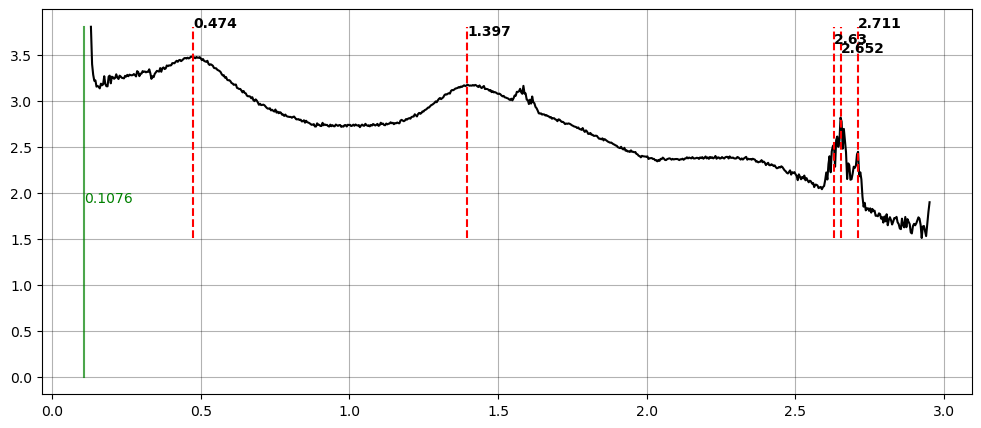

In [189]:
### Show one curve and find peaks

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[-1]
print(protocol)
print(exp.dict['rawinfo']['filename'][-1])

## Pick a curve
file_idx = 250
line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  
flag_log = 1

%matplotlib inline
#%matplotlib ipympl
plt.figure(1, figsize=(12,5)); plt.clf()
q_peaks = Tools.plot_peaks(line_plot, N_peaks_find = 5, fit_param=[0, 1, 0.001], flag_log=flag_log, line_color='k', label_color='r', verbose=1)  #Tools.rand_color(0.5, 0.8)

q_label = [0.1076]
for q in q_label:
    if flag_log:
        y_range = [0, max(np.log(line_plot.y))]
    else:
        y_range = [min(line_plot.y), max(np.log(line_plot.y))]
    plt.plot([q, q], y_range, 'g',  alpha=0.7)
    plt.text(q, y_range[1]/2, str(q), color='g')


##### - __Plot all curves as 2D image__

q_label = [0.47427512 1.39708712 2.63006278 2.6522344  2.711245  ]


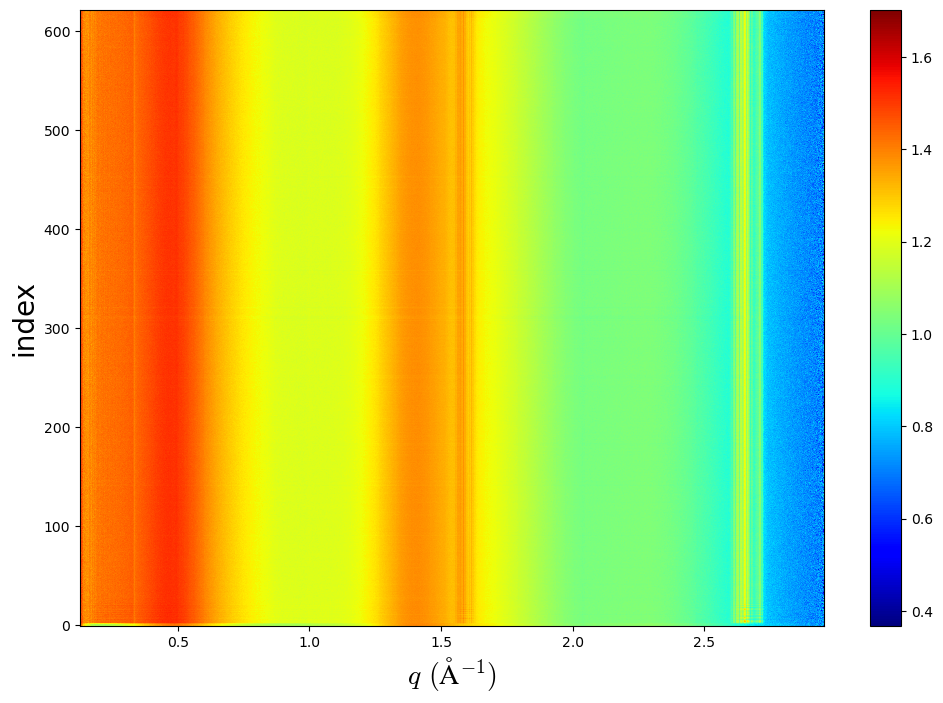

In [190]:
q_label = q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines
flag_log = True

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[-1]


x_axis = exp.dict['analysis'][protocol]['q'] 
I_stack = exp.dict['analysis'][protocol]['I_stack']
# y_axis = exp.dict['metadata']['scan_id'] - exp.dict['metadata']['scan_id'][0]
# y_axis = exp.dict['metadata']['sample_clock'] #- exp.dict['metadata']['sample_clock'][0]

y_axis = np.arange(len(infiles))
if flag_log:
    I_stack = np.log10(I_stack)
    
%matplotlib inline
plt.figure(2, figsize=(12,8)); plt.clf()
# plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), scan_id[0], scan_id[-1]],  aspect='auto') #aspect='auto' 0.005
# # plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), 0, I_stack.shape[0]],  aspect='auto') #aspect='auto' 0.005
# cbar = plt.colorbar(fraction=0.02, pad=0.02, aspect=40) 

# y_axis = np.arange(0, I_stack.shape[0])
X, Y = np.meshgrid(x_axis, y_axis)
#dont know how to change the plotting range in pcolormesh
# plt.pcolormesh(X,Y,I_stack,vmin=.3,vmax=2.8, cmap=mpl.cm.jet); plt.colorbar()
plt.pcolormesh(X,Y,I_stack, cmap=mpl.cm.jet); plt.colorbar()
plt.xlabel(r'$q$ $({\rm \AA}^{-1})$', size=20)
plt.ylabel('index', size=20)
# plt.ylabel('Time (s)')
# plt.xlim(-.2, .2)
# plt.ylim(0, 2)

print('q_label = {}'.format(q_label))
#for q in q_label:
#    plt.plot([q, q], [0, I_stack.shape[0]], 'k',  alpha=0.2)
    

q_label = [0.47427512 1.39708712 2.63006278 2.6522344  2.711245  ]


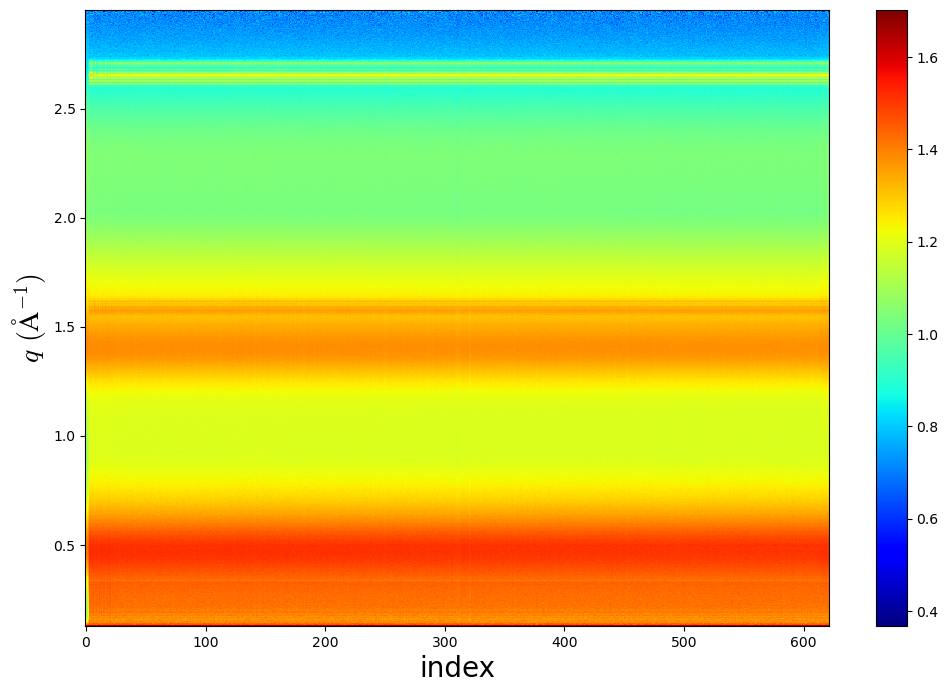

In [191]:
q_label = q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines
flag_log = True

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[-1]


x_axis = exp.dict['analysis'][protocol]['q'] 
I_stack = exp.dict['analysis'][protocol]['I_stack']
# y_axis = exp.dict['metadata']['scan_id'] - exp.dict['metadata']['scan_id'][0]
# y_axis = exp.dict['metadata']['sample_clock'] #- exp.dict['metadata']['sample_clock'][0]

y_axis = np.arange(len(infiles))
if flag_log:
    I_stack = np.log10(I_stack)
    
%matplotlib inline
plt.figure(2, figsize=(12,8)); plt.clf()
# plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), scan_id[0], scan_id[-1]],  aspect='auto') #aspect='auto' 0.005
# # plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), 0, I_stack.shape[0]],  aspect='auto') #aspect='auto' 0.005
# cbar = plt.colorbar(fraction=0.02, pad=0.02, aspect=40) 

# y_axis = np.arange(0, I_stack.shape[0])
X, Y = np.meshgrid( y_axis, x_axis)
#dont know how to change the plotting range in pcolormesh
# plt.pcolormesh(X,Y,I_stack,vmin=.3,vmax=2.8, cmap=mpl.cm.jet); plt.colorbar()
plt.pcolormesh(X,Y,I_stack.T, cmap=mpl.cm.jet) #, vmin=0.2,vmax=2.3); 
plt.colorbar()
plt.ylabel(r'$q$ $({\rm \AA}^{-1})$', size=20)
plt.xlabel('index', size=20)
# plt.ylabel('Time (s)')
# plt.xlim(-.2, .2)
# plt.ylim(0.3, 3)

print('q_label = {}'.format(q_label))
#for q in q_label:
#    plt.plot([q, q], [0, I_stack.shape[0]], 'k',  alpha=0.2)
    